In [1]:
from moralis import evm_api
import os
import json
import requests
from PIL import Image
from io import BytesIO

In [16]:
from get_embeddings import get_single_image_embedding, get_model_info

In [23]:
import torch
from pinecone import Pinecone

In [43]:
from dotenv import load_dotenv
load_dotenv()

True

GETTING ENVIRONMENTAL VARIABLES

In [3]:
moralis_api_key = os.getenv('MORALIS_API_KEY')
pinecone_api_key = os.getenv('PINECONE_API_KEY')

In [4]:
# Wallet address of User I'm using to test
account_address = "0x9966CfE397CeA90D81e1E45F35Fee4723C2dAe6E"

GETTING RECENT NFT PURCHASE

In [5]:
def get_wallet_nft_transfers(account_address, limit):
  # Parameters required by the get_wallet_nft_transfers endpoint
  params = {
    "chain": "eth",
    "format": "decimal",
    "order": "DESC",
    "limit": limit,
    "address": account_address
  }

  wallet_nft_transfers_result = evm_api.nft.get_wallet_nft_transfers(
    api_key=moralis_api_key,
    params=params,
  )

  return wallet_nft_transfers_result

  # Function to get the last bought nft by the user (Moralis doesn't have an endpoint for getting just a user's recent nft purchase exclusively)

def get_last_bought_nft_by_account(account_address, transactions):
    # Filtering transactions based on 'to_address' matching the account_address
    filtered_transactions = [
        txn for txn in transactions if txn['to_address'] == account_address.lower()
    ]
    # Returning the 'to_address' of the most recent transaction if available
    if filtered_transactions:
      return filtered_transactions[0]['token_address'], filtered_transactions[0]['token_id']
    else:
      return None  # Return None if no matching transactions found


In [6]:
def latest_nft_purchase():
    transactions = get_wallet_nft_transfers(account_address, 10)
    token_address, token_id = get_last_bought_nft_by_account(account_address, transactions['result'])
    return token_address, token_id

In [7]:
token_address, token_id = latest_nft_purchase()

In [104]:
print(token_address, token_id)

0x026224a2940bfe258d0dbe947919b62fe321f042 2950


GETTING IMAGE URL OF RECENTLY PURCHASED NFT

In [8]:
def get_multiple_nft_result(address, id):
  body = {
      "tokens": [
          {
              "token_address": address,
              "token_id": id
          },
      ],
      "media_items": True,
      "normalize_metadata": True
  }

  params = {
    "chain": "eth"
  }

  multiple_nft_result = evm_api.nft.get_multiple_nfts(
    api_key=moralis_api_key,
    body=body,
    params=params,
  )

  return multiple_nft_result

In [9]:
def extract_nft_image_url():
    ipfsGateway = "https://ipfs.io/ipfs/"
    ipfs_url = "ipfs://"

    # Parsing the get_multiple_nft_result into a dictionary
    nft_response = get_multiple_nft_result(token_address, token_id)
    metadata = json.loads(nft_response[0]['metadata'])
    image_url = metadata['image']

    # Replace IPFS prefix if necessary
    return image_url.replace(ipfs_url, ipfsGateway) if image_url.startswith(ipfs_url) else image_url

In [10]:
def get_nft_image(image_url):
    response = requests.get(image_url)
    nft_image = Image.open(BytesIO(response.content)).convert("RGB")
    return nft_image

In [11]:
nft_image = get_nft_image(extract_nft_image_url())

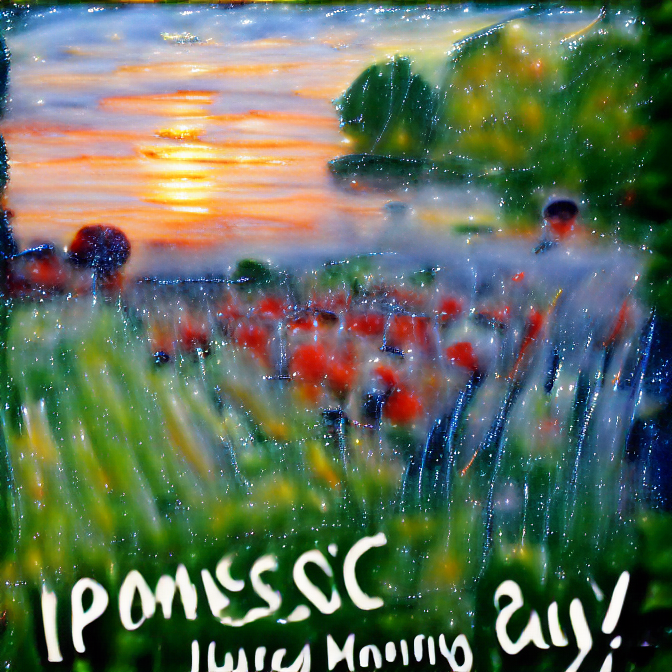

In [12]:
nft_image

In [13]:
clip_model, clip_processor, _ = get_model_info()

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
def get_single_image_embedding(nft_image, processor, model, device: str = device):
    image = processor(
        text=None,
        images=nft_image,
        return_tensors="pt"
    )["pixel_values"].to(device)

    embedding = model.get_image_features(image)

    # Convert to NumPy array and return
    embedding = embedding.cpu().detach().numpy()

    return embedding

In [30]:
nft_image_embedding = get_single_image_embedding(nft_image, clip_processor, clip_model)

In [31]:
nft_image_embedding = nft_image_embedding.flatten().tolist()

In [32]:
type(nft_image_embedding)

list

In [33]:
nft_image_embedding

[0.1016823947429657,
 -0.15038025379180908,
 0.043585434556007385,
 0.06832395493984222,
 -0.3493826389312744,
 -0.134225994348526,
 0.1336362510919571,
 0.20541073381900787,
 -0.03811751306056976,
 -0.10261513292789459,
 -0.5088980793952942,
 0.28213006258010864,
 -0.43740904331207275,
 -0.5734974145889282,
 0.17379289865493774,
 0.08614541590213776,
 -0.4987958073616028,
 0.5233669877052307,
 0.21393175423145294,
 -0.23224401473999023,
 -0.276025652885437,
 0.27820074558258057,
 -0.06371977925300598,
 0.31586045026779175,
 -0.10960803180932999,
 0.47203150391578674,
 -0.09885299205780029,
 0.05641093850135803,
 0.05372258275747299,
 0.0924103856086731,
 0.06299364566802979,
 -0.31692659854888916,
 -0.4311968684196472,
 -0.22017133235931396,
 -0.43322041630744934,
 0.1440100073814392,
 0.09511494636535645,
 -0.46988362073898315,
 -0.1419491320848465,
 0.010058566927909851,
 0.17267924547195435,
 0.2137312889099121,
 -0.1891685575246811,
 0.5673628449440002,
 0.34015166759490967,
 -0.9

In [46]:
pc = Pinecone(api_key=pinecone_api_key)

host = os.environ.get('PINECONE_NFT_RECOMMENDER_HOST')

index = pc.Index(host=host)

INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['c:\\Users\\j\\.vscode\\real-search\\propertyenv\\Lib\\site-packages\\pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference
INFO:pinecone_plugin_interface.logging:Installing plugin inference into Pinecone
INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['c:\\Users\\j\\.vscode\\real-search\\propertyenv\\Lib\\site-packages\\pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference


In [47]:
index.upsert(
    vectors = [
        {"id": account_address, "values": nft_image_embedding}
    ], 
    namespace="user-namespace"
)

{'upserted_count': 1}